# Generate Population from National Transport Survey Data

Generate caveat schedules and attributes inputs from UK NTS data.

Provided example uses toy data. You can access the real [UK travel survey from 2002-2021](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340) from the [UK Data Service](https://beta.ukdataservice.ac.uk).

In [1]:
from pathlib import Path

import pandas as pd
from pam import read
from pam.core import Population
from pam.utils import datetime_to_matsim_time

from caveat.evaluate.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.evaluate.describe.transitions import sequence_prob_plot

In [2]:
dir = Path("data/dummyNTS/")
trips_csv = dir / "trips.tab"
attributes_csv = dir / "individuals.tab"
hhs_csv = dir / "households.tab"

# dir = Path("/home/fred/Data/UKDA-5340-tab/tab")
# trips_csv = dir / "trip_eul_2002-2023.tab"
# attributes_csv = dir / "individual_eul_2002-2023.tab"
# hhs_csv = dir / "household_eul_2002-2023.tab"

assert dir.exists()
assert trips_csv.exists()
assert attributes_csv.exists()
assert hhs_csv.exists()

years = [2021]

write_dir = Path("tmp")
write_dir.mkdir(exist_ok=True)
schedules_path = write_dir / "nts_schedules.csv"
attributes_path = write_dir / "nts_attributes.csv"
home_schedules_path = write_dir / "nts_home_schedules.csv"
home_attributes_path = write_dir / "nts_home_attributes.csv"

In [3]:
travel_diaries = pd.read_csv(
    trips_csv,
    sep="\t",
    usecols=[
        "TripID",
        "JourSeq",
        "DayID",
        "IndividualID",
        "HouseholdID",
        "MainMode_B04ID",
        "TripPurpFrom_B01ID",
        "TripPurpTo_B01ID",
        "TripStart",
        "TripEnd",
        "TripOrigGOR_B02ID",
        "TripDestGOR_B02ID",
        "W5",
        "SurveyYear",
    ],
)
travel_diaries = travel_diaries.rename(
    columns={
        "TripID": "tid",
        "JourSeq": "seq",
        "DayID": "day",
        "IndividualID": "iid",
        "HouseholdID": "hid",
        "TripOrigGOR_B02ID": "ozone",
        "TripDestGOR_B02ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
        "W5": "freq",
        "SurveyYear": "year",
    }
)

travel_diaries = travel_diaries[travel_diaries.year.isin(years)]

travel_diaries.tst = pd.to_numeric(travel_diaries.tst, errors="coerce")
travel_diaries.tet = pd.to_numeric(travel_diaries.tet, errors="coerce")
travel_diaries.ozone = pd.to_numeric(travel_diaries.ozone, errors="coerce")
travel_diaries.dzone = pd.to_numeric(travel_diaries.dzone, errors="coerce")
travel_diaries.freq = pd.to_numeric(travel_diaries.freq, errors="coerce")

travel_diaries["did"] = travel_diaries.groupby("iid")["day"].transform(
    lambda x: pd.factorize(x)[0] + 1
)
travel_diaries["pid"] = [
    f"{i}-{d}" for i, d in zip(travel_diaries.iid, travel_diaries.did)
]

travel_diaries = travel_diaries.loc[
    travel_diaries.groupby("pid")
    .filter(lambda x: pd.isnull(x).sum().sum() < 1)
    .index
]
# travel_diaries.freq = travel_diaries.freq / travel_diaries.groupby("iid").day.transform("nunique")
travel_diaries.loc[travel_diaries.tet == 0, "tet"] = 1440

travel_diaries = travel_diaries.drop(["tid", "day", "year", "did"], axis=1)

mode_mapping = {
    1: "walk",
    2: "bike",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "car",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "car",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop",  #'Food shopping',
    5: "shop",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort",  #'Escort home',
    18: "escort",  #'Escort work',
    19: "escort",  #'Escort in course of work',
    20: "escort",  #'Escort education',
    21: "escort",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}

travel_diaries["mode"] = travel_diaries["mode"].map(mode_mapping)
travel_diaries["oact"] = travel_diaries["oact"].map(purp_mapping)
travel_diaries["dact"] = travel_diaries["dact"].map(purp_mapping)
travel_diaries.tst = travel_diaries.tst.astype(int)
travel_diaries.tet = travel_diaries.tet.astype(int)

travel_diaries.head(20)

,iid,hid,seq,mode,oact,dact,freq,tst,tet,ozone,dzone,pid
0,1,1,1,car,home,visit,0.989618,675,683,7,7,1-1
1,1,1,2,car,visit,other,1.002945,720,735,7,7,1-1
2,1,1,3,car,other,visit,0.989618,770,780,7,7,1-1
3,1,1,4,car,visit,home,0.989618,1110,1130,7,7,1-1
4,1,1,1,car,home,visit,0.999891,760,770,7,7,1-2
5,1,1,2,car,visit,visit,0.999891,790,805,7,7,1-2
6,1,1,3,car,visit,other,1.061665,810,825,7,7,1-2
7,1,1,4,car,other,other,1.061665,845,852,7,7,1-2
8,1,1,5,car,other,visit,0.999891,865,873,7,7,1-2
9,1,1,6,car,visit,escort,1.006313,908,914,7,7,1-2


In [4]:
columns = {
    "SurveyYear": "year",
    "IndividualID": "iid",
    "HouseholdID": "hid",
    "Age_B01ID": "age",
    "Sex_B01ID": "gender",
    "EdAttn1_B01ID": "education",
    "DrivLic_B02ID": "license",
    "CarAccess_B01ID": "car_access",
    "EcoStat_B02ID": "work_status",
    "EthGroupTS_B02ID": "ethnicity",
}
attributes = pd.read_csv(
    attributes_csv, sep="\t", usecols=columns.keys()
).rename(columns=columns)

attributes = attributes[attributes.year.isin(years)]
attributes = attributes[attributes.iid.isin(travel_diaries.iid)]

# expand attributes to days and add pid
pid_to_iid = travel_diaries.set_index("pid")["iid"].to_dict()
expanded_attributes = []
for k, v in pid_to_iid.items():
    expanded_attributes.append(attributes[attributes.iid == v].assign(pid=k))
expanded_attributes = pd.concat(expanded_attributes)
assert set(expanded_attributes.pid) == set(travel_diaries.pid)

# fix special values to zero (DEAD, NULL, NA, etc)
for c in [
    "age",
    "gender",
    "education",
    "license",
    "car_access",
    "work_status",
    "ethnicity",
]:
    expanded_attributes.loc[expanded_attributes[c] < 0, c] = 0
    expanded_attributes.loc[expanded_attributes[c].isnull(), c] = 0

expanded_attributes.head()

,iid,hid,age,gender,ethnicity,education,license,car_access,work_status,year,pid
0,1,2002003369,20,2,1,0,1,2,4,2021,1-1
0,1,2002003369,20,2,1,0,1,2,4,2021,1-2
0,1,2002003369,20,2,1,0,1,2,4,2021,1-3
0,1,2002003369,20,2,1,0,1,2,4,2021,1-4
0,1,2002003369,20,2,1,0,1,2,4,2021,1-5


In [5]:
# additionally extract attributes from household table
# add them to individual table for simplicity
columns = {
    "HouseholdID": "hid",
    "Settlement2011EW_B04ID": "area",
    "SurveyYear": "year",
    "HHIncQISEngTS_B01ID": "income",
    "HHoldNumPeople": "hh_size",
    "HHoldStruct_B02ID": "hh_composition",
    "HHoldNumChildren": "hh_children",
    "NumCar": "hh_cars",
    "NumBike": "hh_bikes",
    "NumMCycle": "hh_motorcycles",
}
hhs = pd.read_csv(hhs_csv, sep="\t", usecols=columns.keys()).rename(
    columns=columns
)
hhs = hhs[hhs.year.isin(years)]

# add hh attributes to individuals
for c in [
    "area",
    "income",
    "hh_size",
    "hh_composition",
    "hh_children",
    "hh_cars",
    "hh_bikes",
    "hh_motorcycles",
]:
    mapper = hhs.set_index("hid")[c].to_dict()
    expanded_attributes[c] = expanded_attributes.hid.map(mapper)

for c in [
    "area",
    "income",
    "hh_size",
    "hh_composition",
    "hh_children",
    "hh_cars",
    "hh_bikes",
    "hh_motorcycles",
]:
    expanded_attributes[c] = (
        pd.to_numeric(expanded_attributes[c], errors="coerce")
        .fillna(0)
        .astype(int)
    )
    expanded_attributes.loc[expanded_attributes[c] < 0, c] = 0
    expanded_attributes.loc[expanded_attributes[c].isnull(), c] = 0

expanded_attributes.drop("hid", axis=1, inplace=True)

expanded_attributes.head()

,iid,age,gender,ethnicity,education,license,car_access,work_status,year,pid,area,income,hh_size,hh_composition,hh_children,hh_cars,hh_bikes,hh_motorcycles
0,1,20,2,1,0,1,2,4,2021,1-1,1,1,1,1,2,1,1,0
0,1,20,2,1,0,1,2,4,2021,1-2,1,1,1,1,2,1,1,0
0,1,20,2,1,0,1,2,4,2021,1-3,1,1,1,1,2,1,1,0
0,1,20,2,1,0,1,2,4,2021,1-4,1,1,1,1,2,1,1,0
0,1,20,2,1,0,1,2,4,2021,1-5,1,1,1,1,2,1,1,0


In [6]:
age_mapping = {
    1: 0,
    2: 1,
    3: 3,
    4: 5,
    5: 11,
    6: 16,
    7: 17,
    8: 18,
    9: 19,
    10: 20,
    11: 21,
    12: 26,
    13: 30,
    14: 40,
    15: 50,
    16: 60,
    17: 65,
    18: 70,
    19: 75,
    20: 80,
    21: 85,
}
age_group_mapping = {
    1: "<5",
    2: "<5",
    3: "<5",
    4: "5-11",
    5: "11-16",
    6: "16-20",
    7: "16-20",
    8: "16-20",
    9: "16-20",
    10: "20-30",
    11: "20-30",
    12: "20-30",
    13: "30-40",
    14: "40-50",
    15: "50-70",
    16: "50-70",
    17: "50-70",
    18: "70+",
    19: "70+",
    20: "70+",
    21: "70+",
}
gender_mapping = {0: "unknown", 1: "M", 2: "F"}
education_mapping = {0: "unknown", 1: "Y", 2: "N"}
license_mapping = {0: "unknown", 1: "yes", 2: "yes", 3: "no"}
car_access_mapping = {
    0: "unknown",
    1: "yes",
    2: "yes",
    3: "yes",
    4: "yes",
    5: "no",
    6: "no",
}
work_status_mapping = {
    0: "unemployed",
    1: "employed",
    2: "employed",
    3: "unemployed",
    4: "unemployed",
    5: "student",
    6: "unemployed",
}
area_mapping = {
    0: "unknown",
    1: "suburban",
    2: "urban",
    3: "rural",
    4: "rural",
    5: "scotland",
}
ethnicity_mapping = {0: "unknown", 1: "white", 2: "non-white"}
hh_composition_mapping = {
    0: "unknown",
    1: "1adult",
    2: "2adults",
    3: "3+adults",
    4: "single_parent",
    5: "2adult_1+child",
    6: "3+adult_1+child",
}
mappings = {
    "age": age_mapping,
    "gender": gender_mapping,
    "education": education_mapping,
    "license": license_mapping,
    "car_access": car_access_mapping,
    "work_status": work_status_mapping,
    "area": area_mapping,
    "ethnicity": ethnicity_mapping,
    "hh_composition": hh_composition_mapping,
}

expanded_attributes["age_group"] = expanded_attributes["age"].map(
    age_group_mapping
)

for c, mapping in mappings.items():
    if c in expanded_attributes.columns:
        expanded_attributes[c] = expanded_attributes[c].map(mapping)

In [7]:
def filter_home_based(population: Population):
    new = Population()
    for _, _, person in population.people():
        if person.plan.first == "home" and person.plan.last == "home":
            new.add(person)
    return new


def squash(before: list, following: list, act="home") -> list:
    if not following:
        return before
    a = before[-1]
    b = following[1]
    if a.act == act and b.act == act:
        a.end_time = b.end_time
        following = following[2:]
        return squash(before, following, act)
    else:
        before = before + following[:2]
        following = following[2:]
        return squash(before, following, act)


def squash_population(population: Population, act="home"):
    new = Population()
    for _, _, person in population.people():
        person.plan.day = squash(
            [person.plan.day[0]], person.plan.day[1:], act=act
        )
        new.add(person)
    return new

Using from-to activity parser using 'oact' and 'dact' columns
Adding pid->hh mapping to persons_attributes from trips.

        Unable to load household area ('hzone') - not found in trips_diary or unable to build from attributes.
        Pam will try to infer home location from activities, but this behaviour is not recommended.
        
Using freq of 'None' for all trips.
 Person pid:2-5 hid:1 plan does not start with 'home' activity: work
 Person pid:2-6 hid:1 plan does not start with 'home' activity: work
 Person pid:2-7 hid:1 plan does not start with 'home' activity: work
 Person pid:3-4 hid:1 plan does not start with 'home' activity: education


Raw size:  {'num_households': 3, 'num_people': 39, 'num_activities': 188, 'num_legs': 149}
PAM fix:  {'num_households': 3, 'num_people': 39, 'num_activities': 175, 'num_legs': 136}
home based size:  {'num_households': 33, 'num_people': 33, 'num_activities': 149, 'num_legs': 116}
Squash home size:  {'num_households': 33, 'num_people': 33, 'num_activities': 147, 'num_legs': 114}
squash work size:  {'num_households': 33, 'num_people': 33, 'num_activities': 147, 'num_legs': 114}
squash edu size:  {'num_households': 33, 'num_people': 33, 'num_activities': 147, 'num_legs': 114}
PAM 2nd fix:  {'num_households': 33, 'num_people': 33, 'num_activities': 147, 'num_legs': 114}


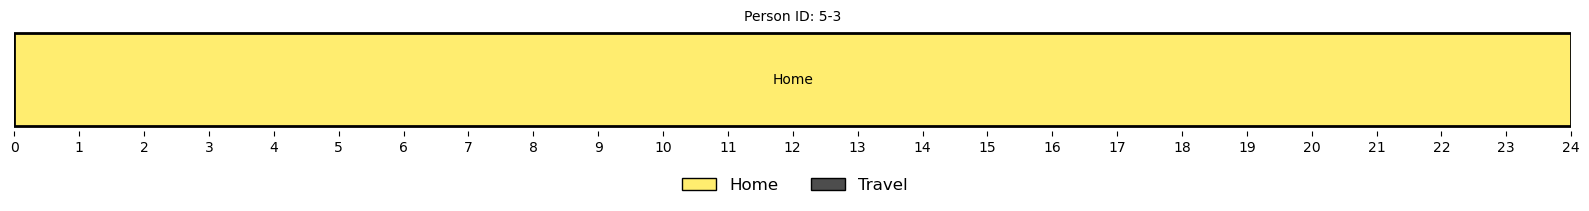

In [8]:
pam_population = read.load_travel_diary(
    trips=travel_diaries,
    persons_attributes=expanded_attributes,
    trip_freq_as_person_freq=True,
)
print("Raw size: ", pam_population.stats)
pam_population.fix_plans()
print("PAM fix: ", pam_population.stats)
pam_population = filter_home_based(pam_population)
print("home based size: ", pam_population.stats)
pam_population = squash_population(pam_population, "home")
print("Squash home size: ", pam_population.stats)
pam_population = squash_population(pam_population, "work")
print("squash work size: ", pam_population.stats)
pam_population = squash_population(pam_population, "education")
print("squash edu size: ", pam_population.stats)
pam_population.fix_plans()
print("PAM 2nd fix: ", pam_population.stats)

pam_population.random_person().plot()

In [9]:
# 2020

# Raw size:  {'num_households': 2675, 'num_people': 25119, 'num_activities': 93189, 'num_legs': 68070}
# PAM fix:  {'num_households': 2675, 'num_people': 25119, 'num_activities': 93159, 'num_legs': 68040}
# home based size:  {'num_households': 23452, 'num_people': 23452, 'num_activities': 87870, 'num_legs': 64418}
# Squash home size:  {'num_households': 23452, 'num_people': 23452, 'num_activities': 87532, 'num_legs': 64080}
# squash work size:  {'num_households': 23452, 'num_people': 23452, 'num_activities': 87165, 'num_legs': 63713}
# squash edu size:  {'num_households': 23452, 'num_people': 23452, 'num_activities': 87162, 'num_legs': 63710}
# PAM 2nd fix:  {'num_households': 23452, 'num_people': 23452, 'num_activities': 87162, 'num_legs': 63710}

# 2023

# Raw size:  {'num_households': 6130, 'num_people': 64366, 'num_activities': 250465, 'num_legs': 186099}
# PAM fix:  {'num_households': 6130, 'num_people': 64366, 'num_activities': 250245, 'num_legs': 185879}
# home based size:  {'num_households': 59265, 'num_people': 59265, 'num_activities': 233085, 'num_legs': 173820}
# Squash home size:  {'num_households': 59265, 'num_people': 59265, 'num_activities': 231640, 'num_legs': 172375}
# squash work size:  {'num_households': 59265, 'num_people': 59265, 'num_activities': 230784, 'num_legs': 171519}
# squash edu size:  {'num_households': 59265, 'num_people': 59265, 'num_activities': 230757, 'num_legs': 171492}
# PAM 2nd fix:  {'num_households': 59265, 'num_people': 59265, 'num_activities': 230757, 'num_legs': 171492}

In [10]:
def dt_to_min(dt) -> int:
    h, m, s = datetime_to_matsim_time(dt).split(":")
    return (int(h) * 60) + int(m)


def pam_to_schedules(population: Population) -> pd.DataFrame:
    """write trace of population. Ignoring trips."""
    record = []
    for uid, (hid, pid, person) in enumerate(population.people()):
        for i in range(0, len(person.plan) - 1, 2):
            record.append(
                [
                    uid,
                    hid,
                    person.plan[i].act,
                    dt_to_min(person.plan[i].start_time),
                    dt_to_min(person.plan[i + 1].end_time),
                ]
            )
        record.append(
            [
                uid,
                hid,
                person.plan[-1].act,
                dt_to_min(person.plan[-1].start_time),
                dt_to_min(person.plan[-1].end_time),
            ]
        )

    df = pd.DataFrame(record, columns=["pid", "hid", "act", "start", "end"])
    df["duration"] = df.end - df.start
    return df


schedules = pam_to_schedules(population=pam_population)

attributes = pd.DataFrame(
    [
        {**{"pid": pid}, **p.attributes}
        for pid, (_, _, p) in enumerate(pam_population.people())
    ]
).drop(["iid", "year"], axis=1)
attributes.describe()

assert set(schedules.pid).issubset(set(attributes.pid))

schedules.to_csv(schedules_path, index=False)
attributes.to_csv(attributes_path, index=False)

schedules.describe()

,pid,start,end,duration
count,147.000000,147.000000,147.000000,147.000000
mean,14.537415,687.088435,1010.353741,323.265306
std,9.846265,412.959282,294.522037,287.508769
min,0.000000,0.000000,465.000000,6.000000
25%,6.000000,469.500000,782.500000,52.000000
50%,13.000000,805.000000,955.000000,310.000000
75%,23.500000,985.000000,1290.000000,523.000000
max,32.000000,1325.000000,1440.000000,1440.000000


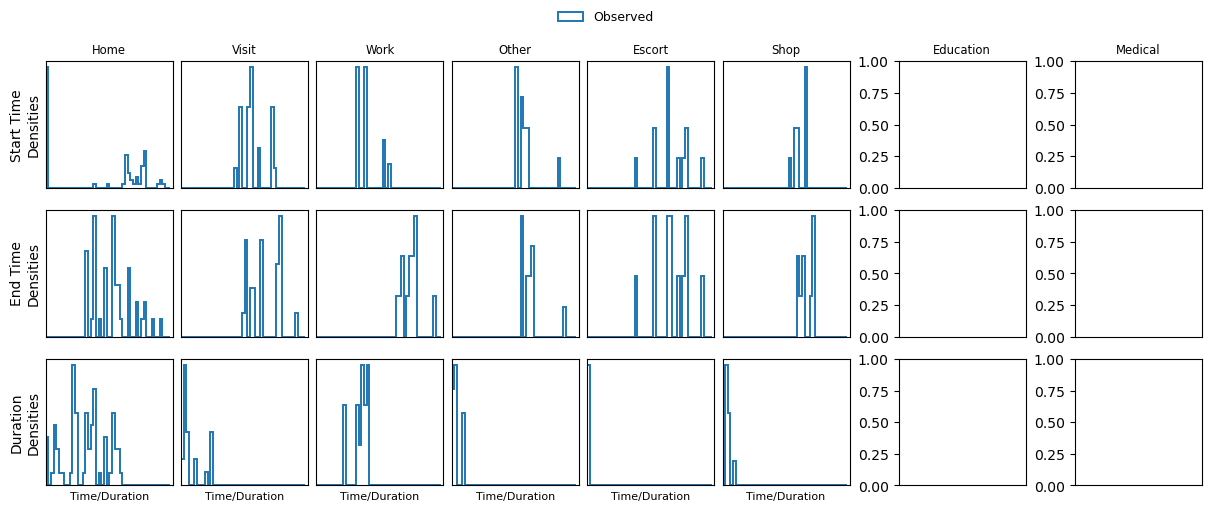

In [11]:
_ = times_distributions_plot(schedules, ys={})

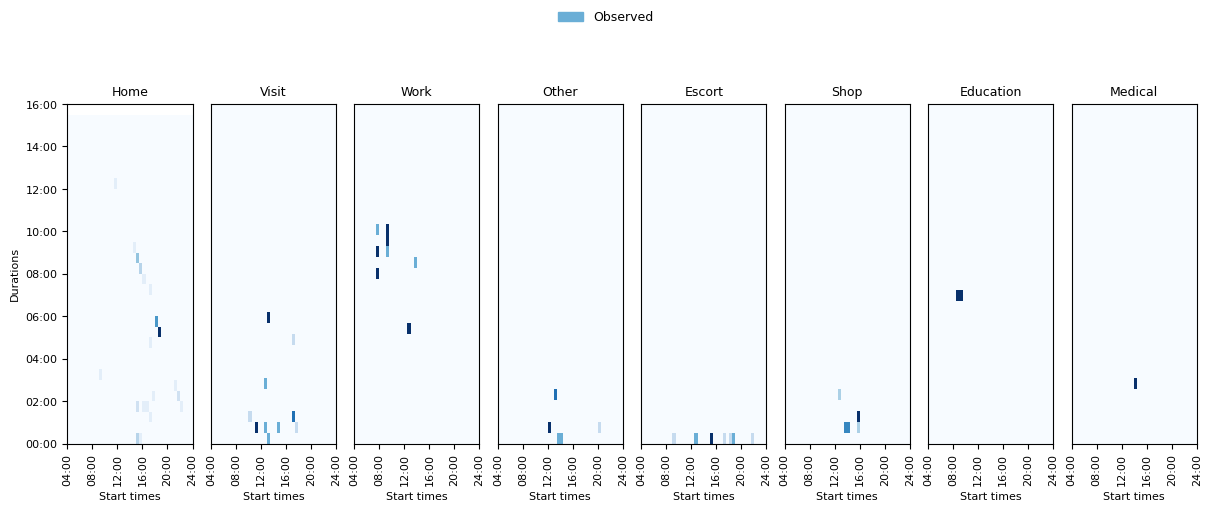

In [12]:
_ = joint_time_distributions_plot(schedules, ys={})

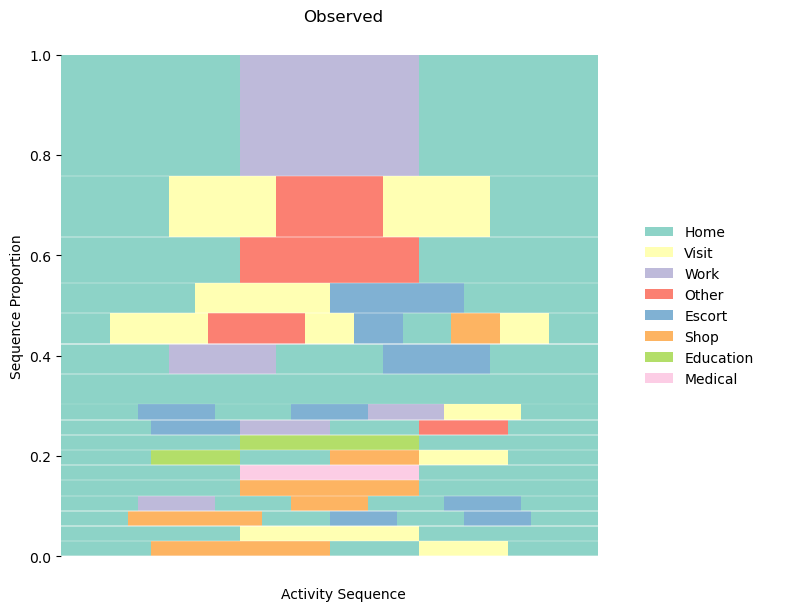

In [13]:
_ = sequence_prob_plot(schedules, ys={}, figsize=(8, 6))